In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hankel

# We need the spline interpolation to obtain a smooth function that can be transformed back to the original function
from scipy.interpolate import InterpolatedUnivariateSpline as spline

Let's define some functions of r

$$a = \frac{1}{r^2 + 1}$$

$$b = e^{-r}$$

$$c = sin(r)$$


In [2]:
a = lambda r: 1 / (np.power(r,2) + 1)
b = lambda r: np.exp(-2*r)
c = lambda r: np.sin(r)
d = lambda r: r / np.power(1 + np.power(r,2), 1.5)

Define a "analytical" non-filtered approach hankel transform from <i>hankel</i>

In [3]:
ht = hankel.HankelTransform(nu=1, N=500, h=0.0005)

In [4]:
realspace = np.linspace(0, 100, 300)[1:]  #  Realspace domain
hankelspace = np.logspace(-5, 15, 300) #  Hankel space domain

In [5]:
h_a = ht.transform(a, hankelspace, ret_err=False)
h_b = ht.transform(b, hankelspace, ret_err=False)
h_c = ht.transform(c, hankelspace, ret_err=False)
h_d = ht.transform(d, hankelspace, ret_err=False)

(-1.0, 1.0)

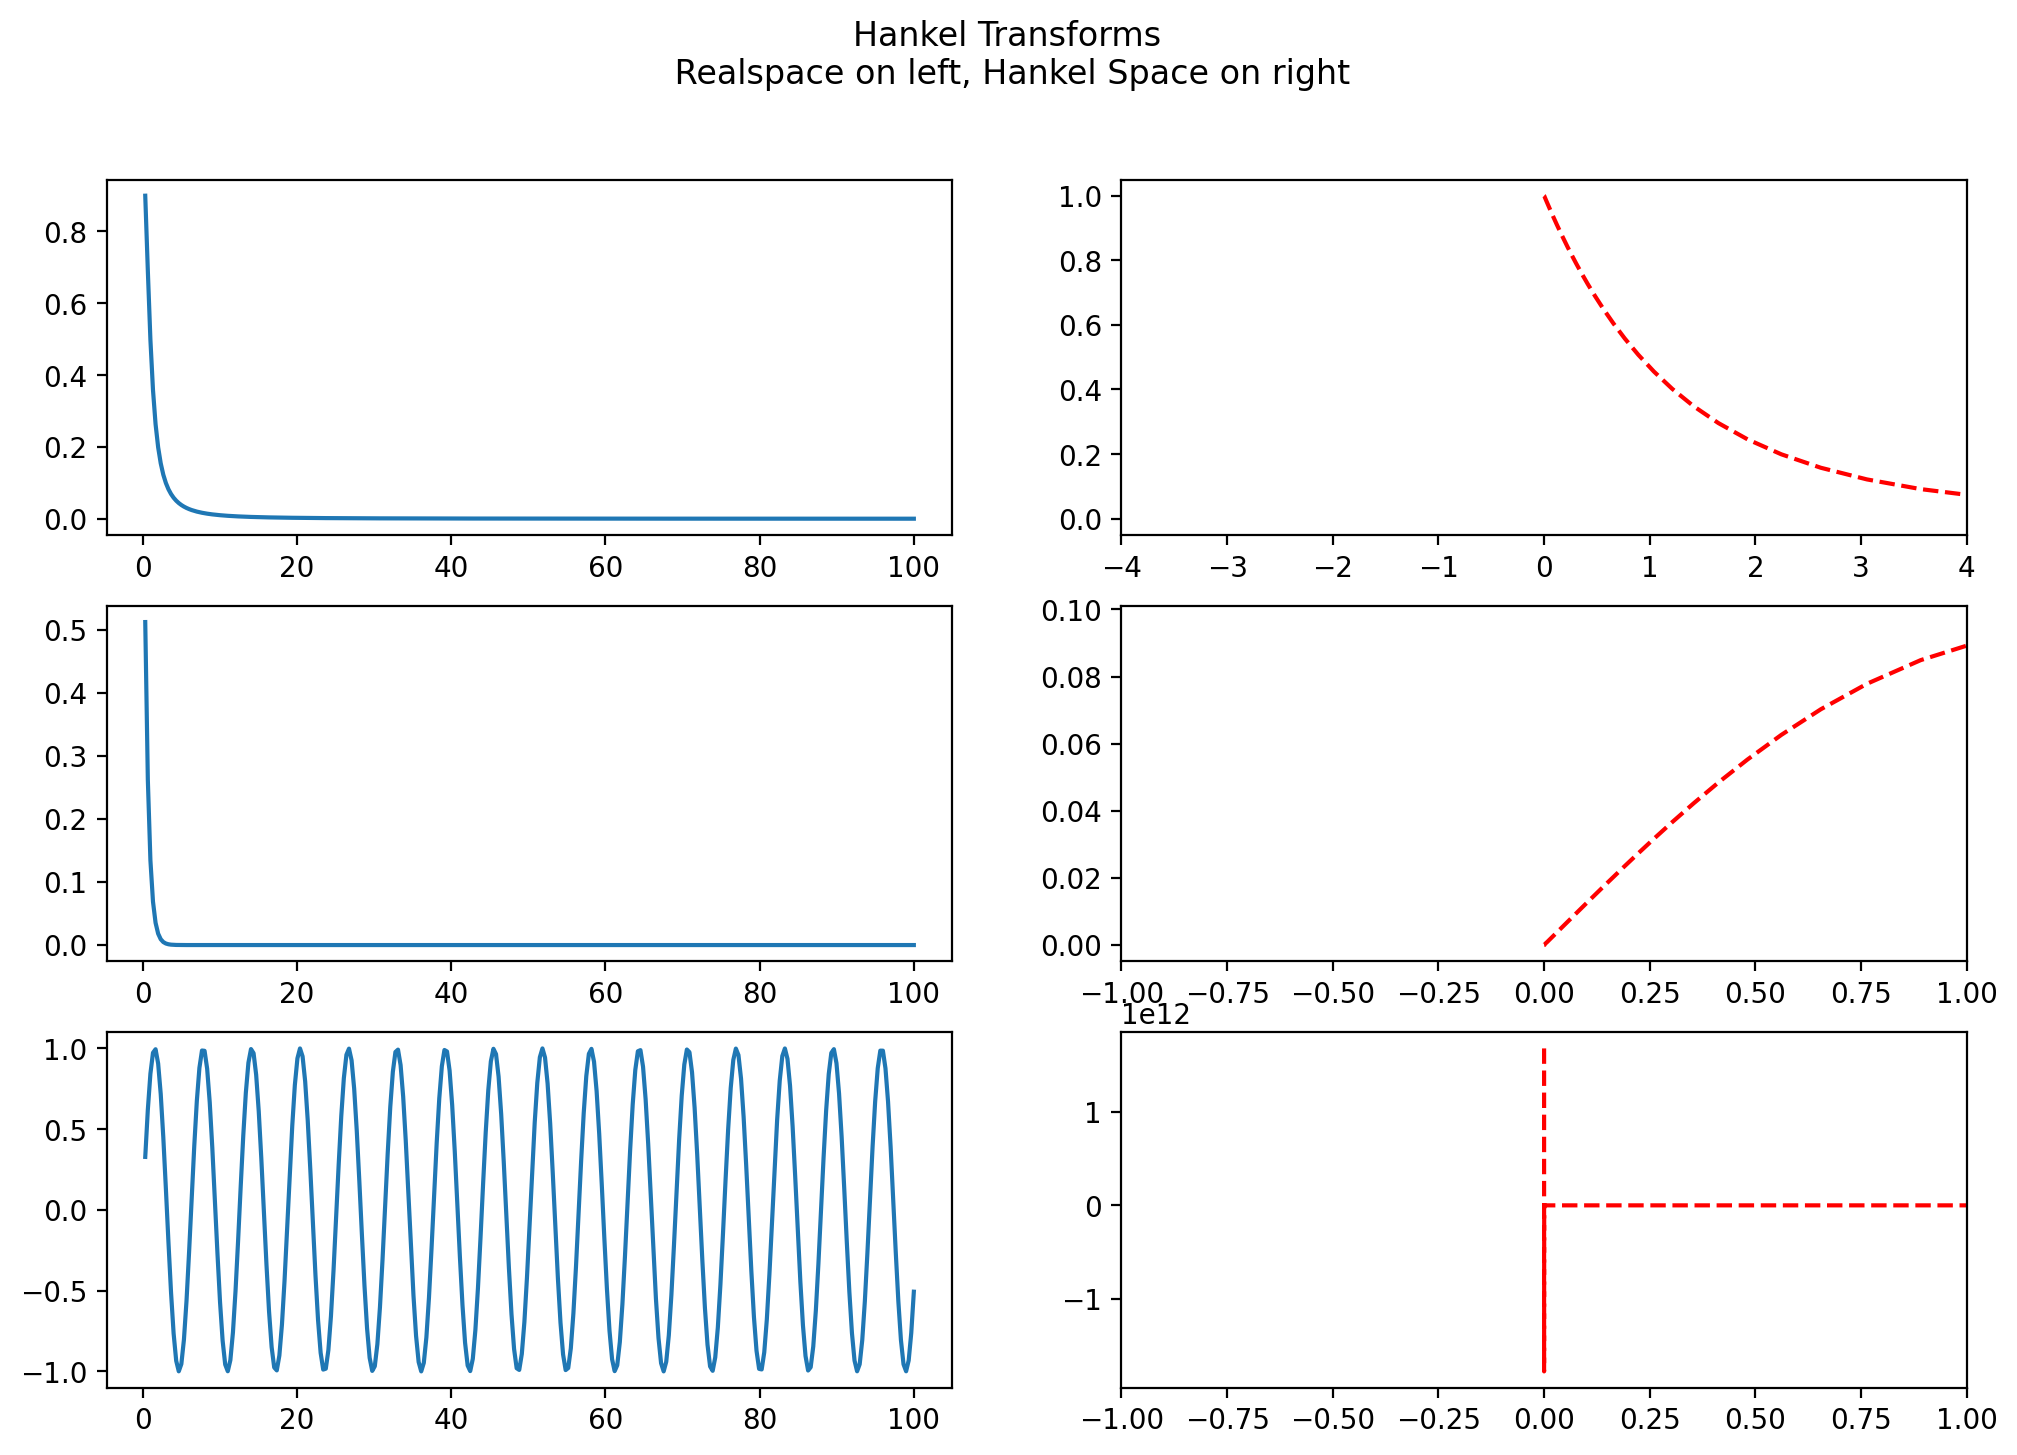

In [6]:
# Plot A
plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(321)
plt.plot(realspace, a(realspace))
plt.suptitle("Hankel Transforms\n Realspace on left, Hankel Space on right")
plt.subplot(322)
plt.xlim([-4, 4])
plt.plot(hankelspace, h_a, "r--")
# Plot B
plt.subplot(323)
plt.plot(realspace, b(realspace))
plt.subplot(324)
plt.plot(hankelspace, h_b, "r--")
plt.xlim([-1, 1])
# Plot C
plt.subplot(325)
plt.plot(realspace, c(realspace))
plt.subplot(326)
plt.plot(hankelspace, h_c, "r--")
plt.xlim([-1, 1])

Inverting the Hankel transformations to recover $f(x)$

In [7]:
# Compute inverse hankel transformations by splining the discrete hankel transformation and running the inverse 
spline_a = spline(hankelspace, h_a)
spline_b = spline(hankelspace, h_b)
spline_c = spline(hankelspace, h_c)

recover_a = ht.transform(spline_a, realspace, inverse=True, ret_err=False)
recover_b = ht.transform(spline_b, realspace, inverse=True, ret_err=False)
recover_c = ht.transform(spline_c, realspace, inverse=True, ret_err=False)

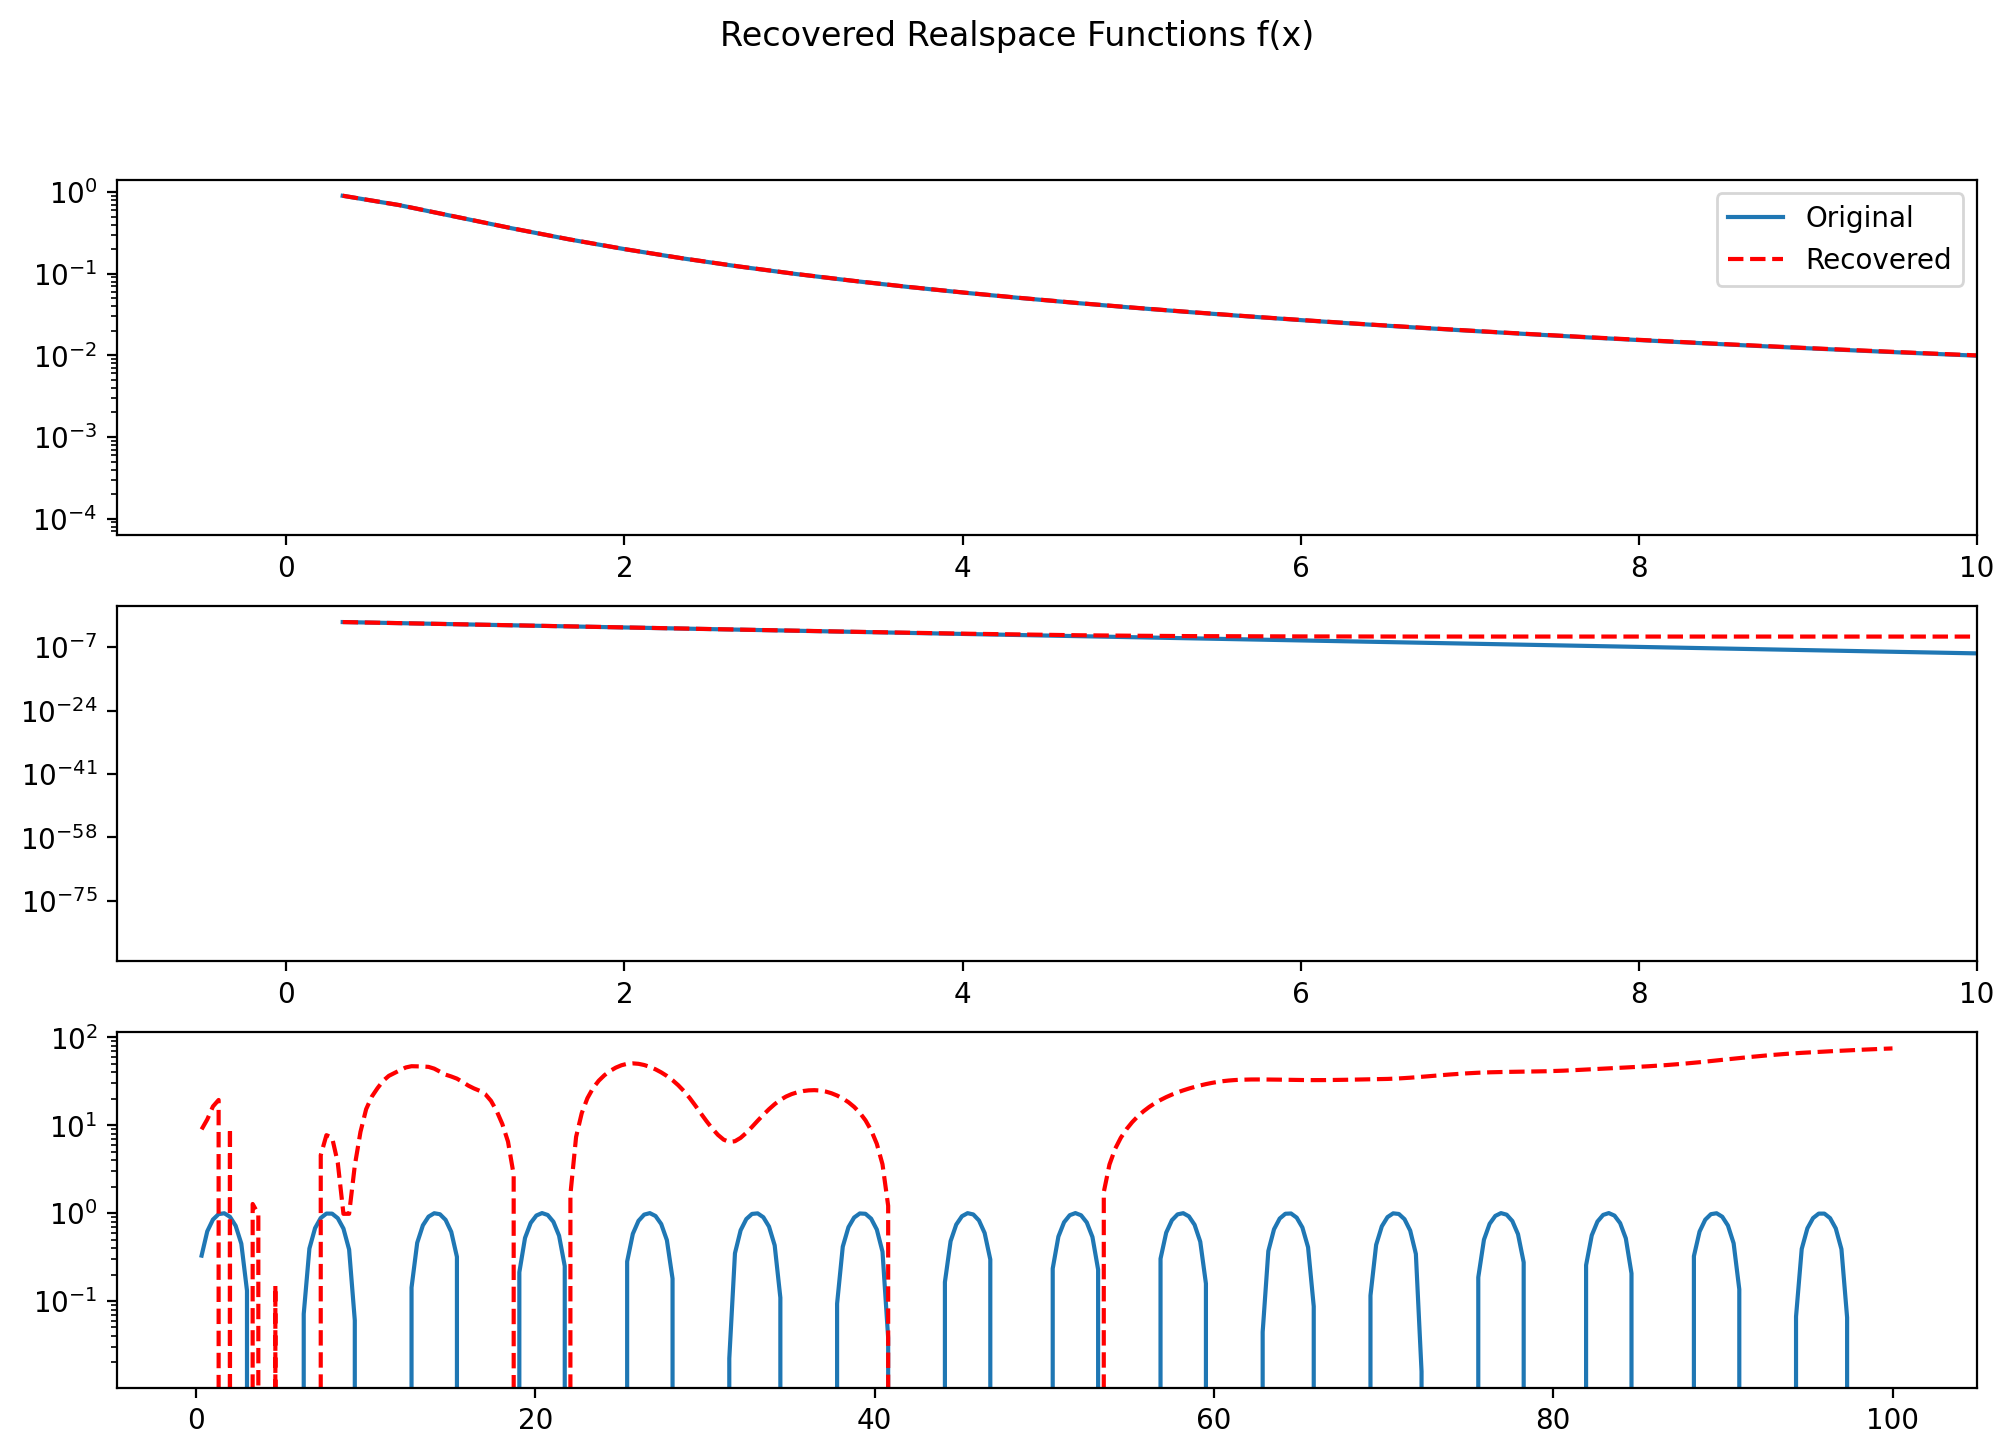

In [8]:
# Recovered A
plt.figure(figsize=(12,8), dpi=200, facecolor='w', edgecolor='k')
plt.suptitle("Recovered Realspace Functions f(x)")
plt.subplot(311)
plt.plot(realspace, a(realspace), label='Original')
plt.plot(realspace, recover_a, "r--", label='Recovered')
plt.xlim([-1,10])
plt.yscale('log')
plt.legend()
# Recovered B
plt.subplot(312)
plt.plot(realspace, b(realspace))
plt.plot(realspace, recover_b, "r--")
plt.xlim([-1,10])
plt.yscale('log')
# Recovered C
plt.subplot(313)
plt.plot(realspace, c(realspace))
plt.plot(realspace, recover_c, "r--")
plt.yscale('log')

For the purposes of troubleshooting and visualization, we will use equation a:
    $$a = \frac{1}{r^2 + 1}$$

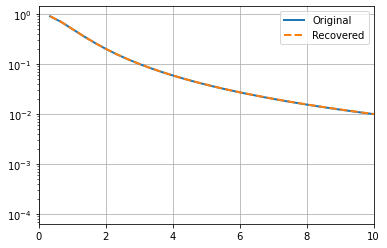

In [9]:
# Recovered, example taken from hankel user guide

fig,ax = plt.subplots(1,1,sharex=True,gridspec_kw={"hspace":0})

ax.semilogy(realspace,a(realspace), linewidth=2,label='Original')
ax.semilogy(realspace,recover_a,ls='--',linewidth=2,label='Recovered')
ax.grid(True)
ax.legend(loc='best')
ax.set_xlim(0,10)

#ax[1].plot(realspace, np.abs(a(realspace)/recover_a-1))
#ax[1].set_yscale('log')
#ax[1].set_ylim(None,30)
#ax[1].grid(True)
#ax[1].set_ylabel("Rel. Diff.")
plt.show()


# Digital Filters to obtain the Hankel Transform
### From Guptasarma and Singh, 1997

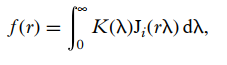

In [10]:
# Load the 47 point J1 filter from Guptasarma 1997
# n = 47

gupFilter = np.genfromtxt('gup1997J147pt.csv', float, delimiter=',').flatten()
print(f"n={len(gupFilter)} Filter loaded")
print(gupFilter)

n=47 Filter loaded
[ 3.17926147e-06 -9.73811661e-06  1.64866227e-05 -1.81501261e-05
  1.87556556e-05 -1.14655041e-06  1.53799734e-05 -6.95628274e-06
  1.41881556e-05  3.41445666e-06  2.13941716e-05  2.34962369e-05
  4.84340283e-05  7.33732979e-05  1.27703784e-04  2.08120026e-04
  3.49803899e-04  5.79107815e-04  9.65887918e-04  1.60401274e-03
  2.66903778e-03  4.43111590e-03  7.35631696e-03  1.21782796e-02
  2.01097829e-02  3.30096953e-02  5.37143592e-02  8.60516613e-02
  1.34267607e-01  2.00125033e-01  2.74027506e-01  3.18168749e-01
  2.41655667e-01 -5.40549162e-02 -4.46912952e-01 -1.92231886e-01
  5.52376754e-01 -3.57429049e-01  1.41510519e-01 -4.61421935e-02
  1.48273762e-02 -5.07479209e-03  1.83829714e-03 -6.67742804e-04
  2.21277518e-04 -5.66248733e-05  7.88229203e-06]


In [11]:
# Abscissae:
def abscissaeJ1(r):
    # Returns the lambdas used in the method of Guptasarma and Singh 1997
    # function f(lambda) is evaluated at these lambdas
    
    # 47 point filter parameters:
    a = -3.05078187595e0
    s = 1.10599010095e-1
    # 140 point filter parameters
    #a = -7.91001919000e0
    #s = 8.79671439570e-2
    rangefunc = np.arange(0, len(gupFilter))[:,np.newaxis]

    eval_points = (1 / r) * np.power(10, a + (rangefunc * s))
    
    return eval_points

def filteredHankel(r, ufunc):
    # Calculates the J1 Hankel Transform with a 47 point filter
    # r: points to calculate the transform at
    # ufunc: callable function to be hankel transformed
    lambdas = abscissaeJ1(r)
    
    K = ufunc(lambdas)
    
    prod = np.multiply(gupFilter, K.T).sum(axis=1) / r
    return prod

filteredHankel(np.array([5, 10, 11]), a)

array([0.19595809, 0.0999827 , 0.0909038 ])

In [12]:
# Hankel Transform Functions
tf8 = lambda r: r / np.power(1 + np.power(r, 2), 1.5)
tf9 = lambda r: r * np.exp(-(np.power(r, 2) / 4)) / 4
tf10 = lambda r: (np.sqrt(np.power(r, 2) + 1) - 1) / r / np.sqrt(np.power(r, 2) + 1)

f8 = lambda l: l * np.exp(-l) 
f9 = lambda l: np.power(l,2) * np.exp(-1* np.power(l,2)) 
f10 = lambda l: np.exp(-l) 

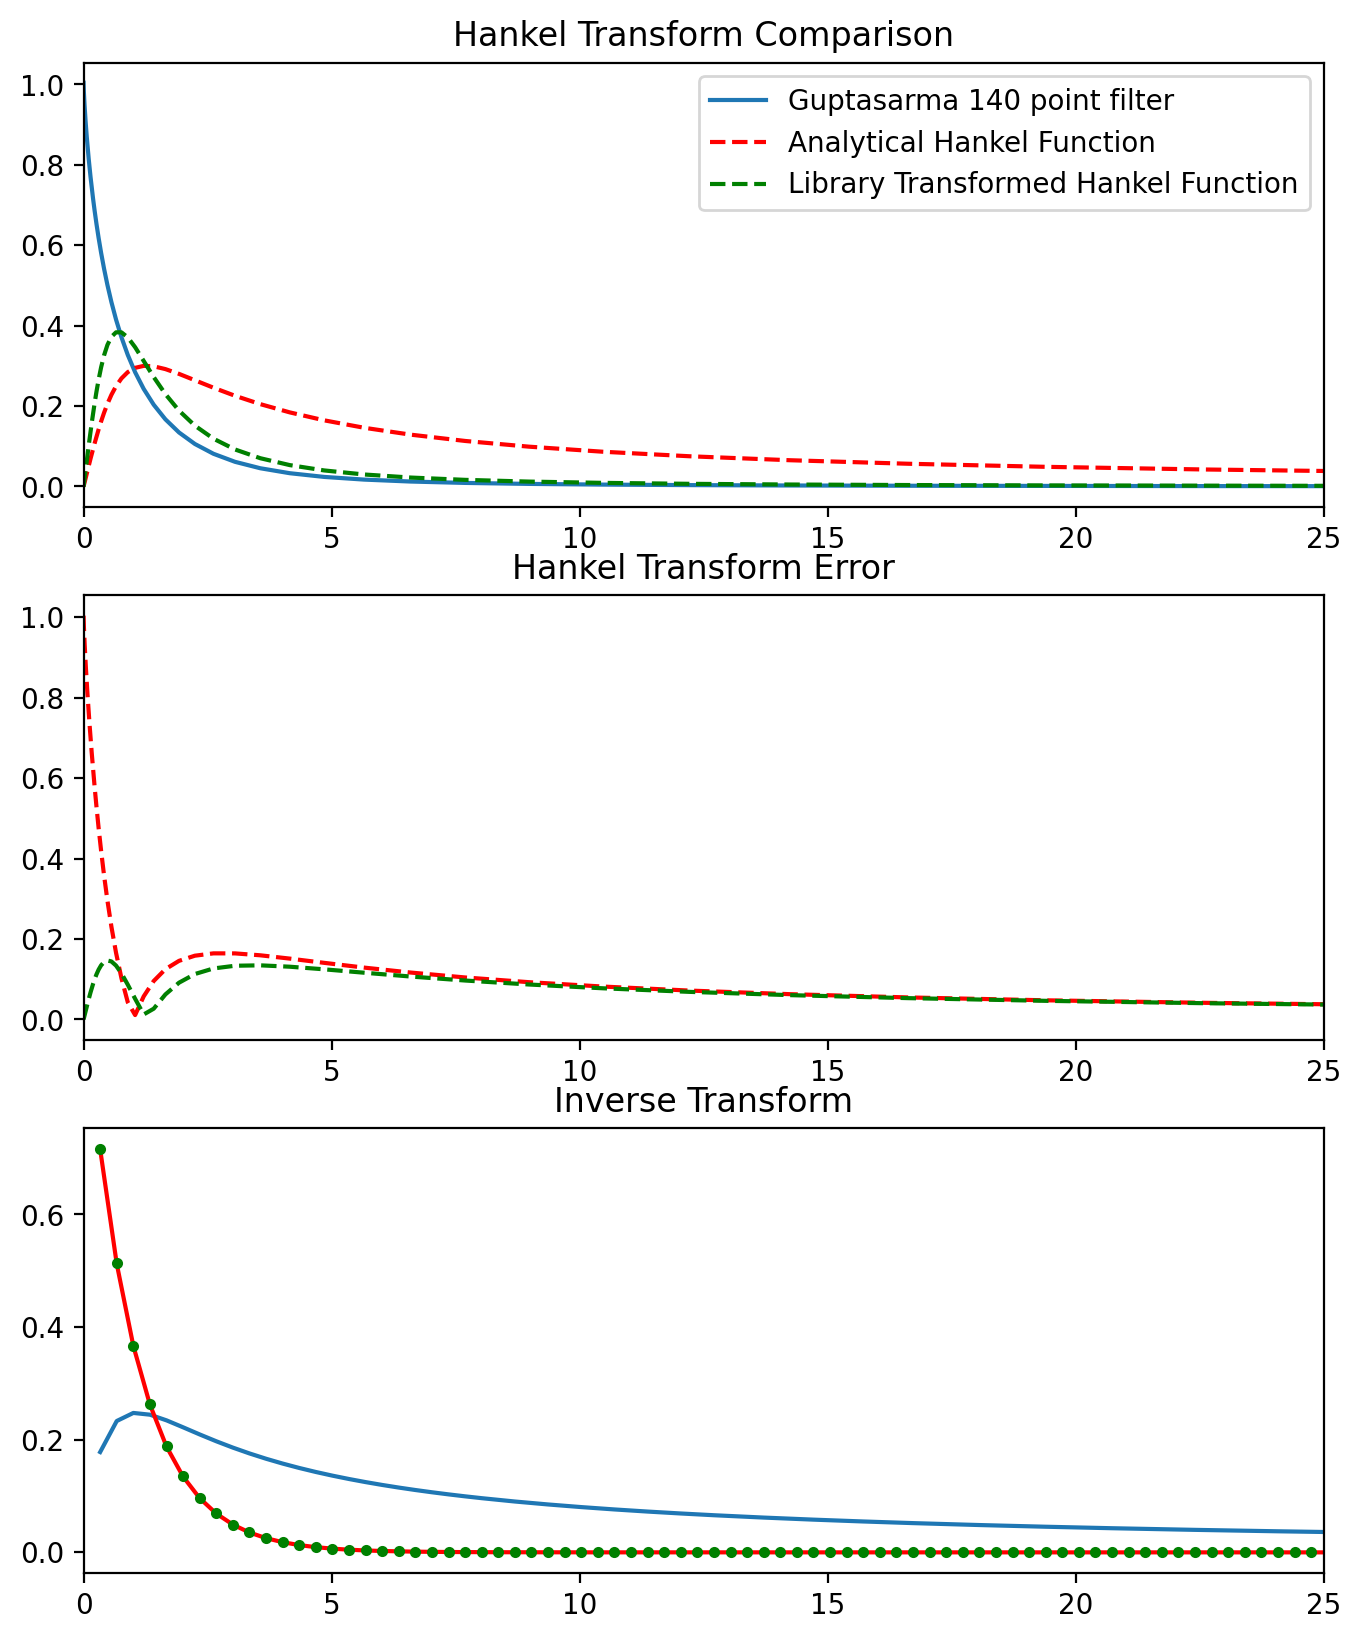

In [13]:
# Input function to test
in_func = tf10
orig_func = f10
# Forward Hankel Testing
filterHankel = filteredHankel(hankelspace, in_func)
analyticalHankel = in_func(hankelspace)
libraryHankel = ht.transform(orig_func, hankelspace, ret_err=False)

# Interpolate spline for to convert points into functions
inversespline_filter = spline(hankelspace, filterHankel)
inversespline_library = spline(hankelspace, libraryHankel)

# Carry out inverse transform
inverse_filter = filteredHankel(realspace, inversespline_filter)
inverse_library = ht.transform(inversespline_library, realspace, inverse=True, ret_err=False)

# Left side is using Guptasarma Filters
plt.figure(figsize=(8,10), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(hankelspace, filterHankel, label='Guptasarma 140 point filter')
plt.plot(hankelspace, analyticalHankel, "r--", label='Analytical Hankel Function')
plt.plot(hankelspace, libraryHankel, "g--", label='Library Transformed Hankel Function')
plt.xlim([0, 25])
plt.legend()
plt.title('Hankel Transform Comparison')

plt.subplot(312)
plt.title('Hankel Transform Error')
plt.plot(hankelspace, abs(filterHankel-analyticalHankel), "r--")
plt.plot(hankelspace, abs(libraryHankel-analyticalHankel), "g--")
plt.xlim([0, 25])

plt.subplot(313)
plt.title('Inverse Transform')
plt.plot(realspace, inverse_filter)
plt.plot(realspace, orig_func(realspace), 'r')
plt.plot(realspace, inverse_library, 'g.')
plt.xlim([0, 25])
plt.show()


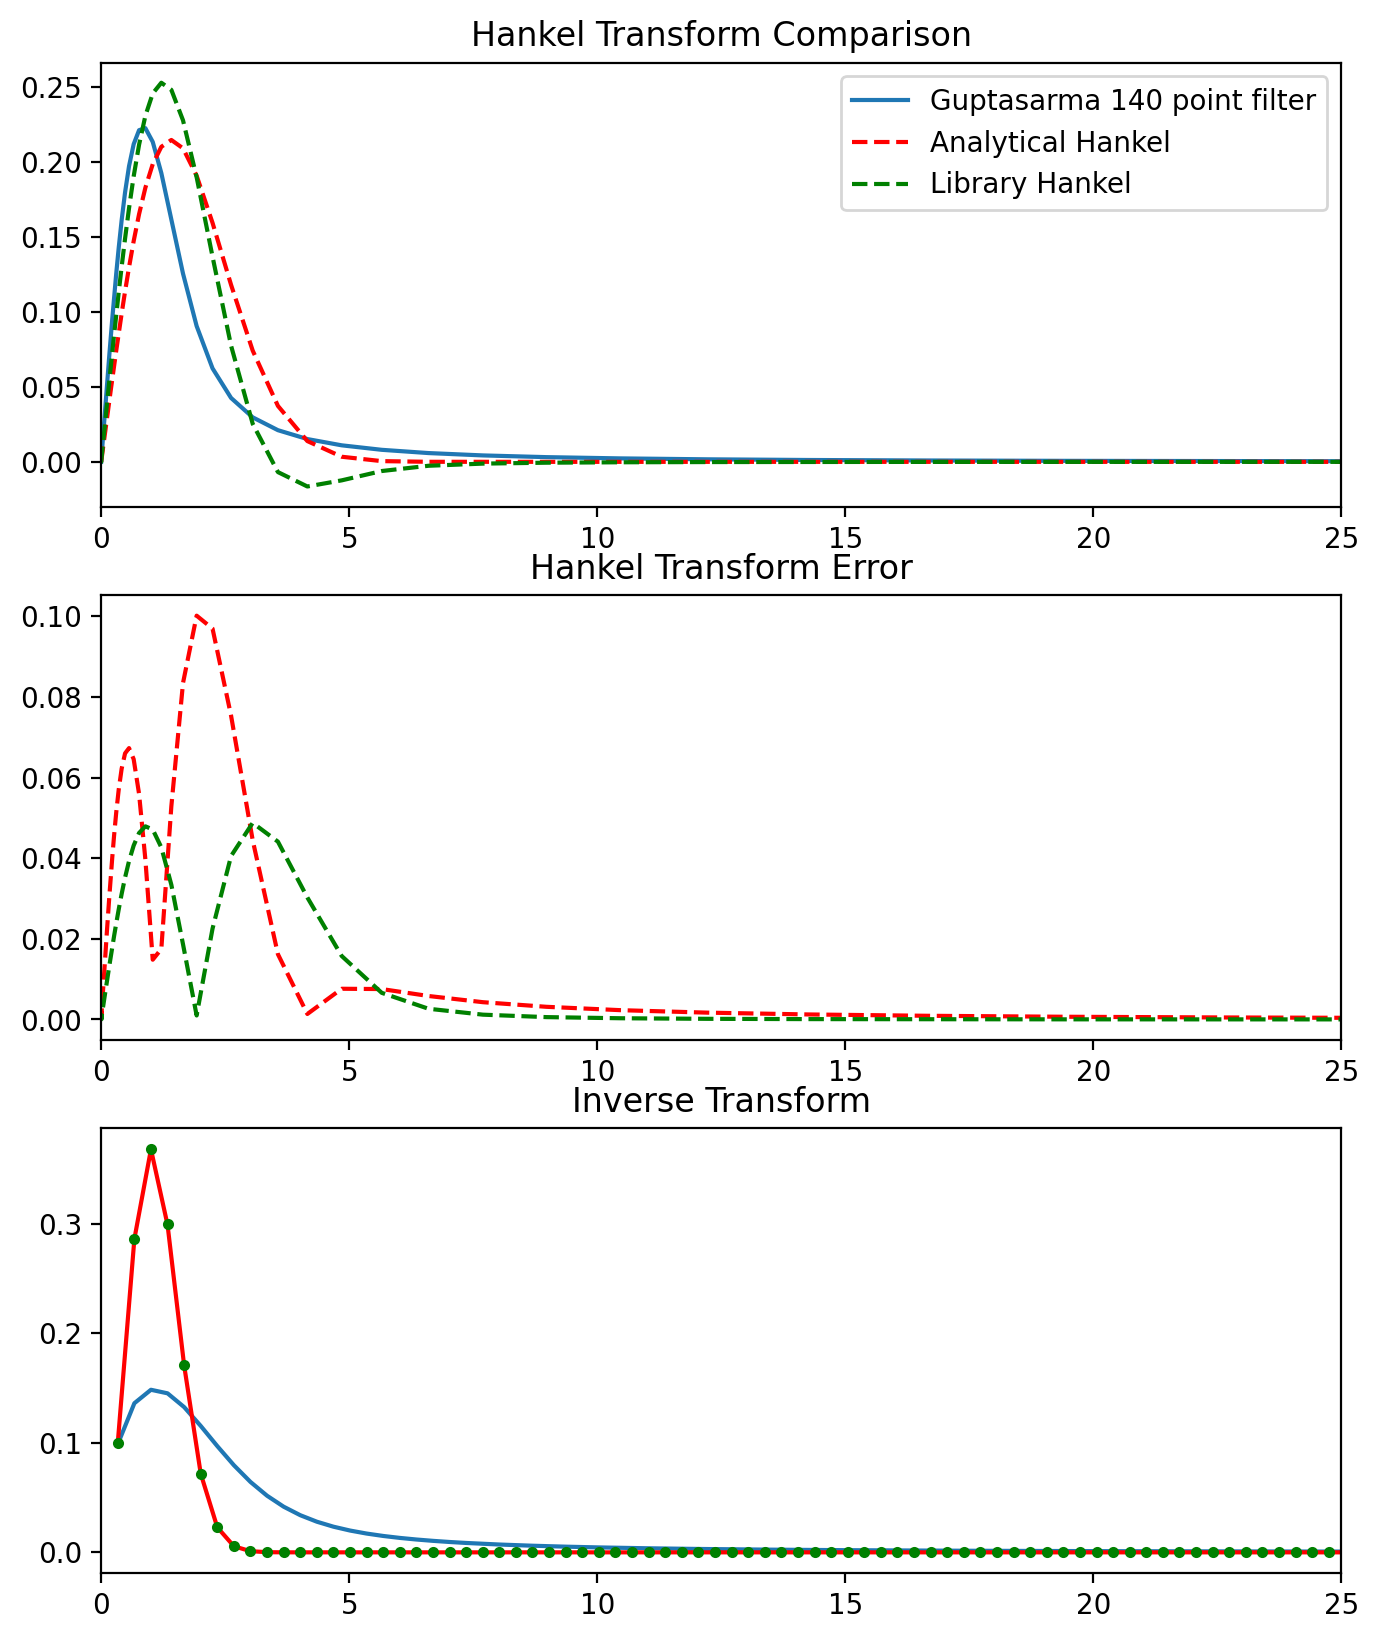

In [14]:
# Input function to test
in_func = tf9
orig_func = f9
# Forward Hankel Testing
filterHankel = filteredHankel(hankelspace, in_func)
analyticalHankel = in_func(hankelspace)
libraryHankel = ht.transform(orig_func, hankelspace, ret_err=False)

# Interpolate spline for to convert points into functions
inversespline_filter = spline(hankelspace, filterHankel)
inversespline_library = spline(hankelspace, libraryHankel)

# Carry out inverse transform
inverse_filter = filteredHankel(realspace, inversespline_filter)
inverse_library = ht.transform(inversespline_library, realspace, inverse=True, ret_err=False)


# Left side is using Guptasarma Filters
plt.figure(figsize=(8,10), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(hankelspace, filterHankel, label='Guptasarma 140 point filter')
plt.plot(hankelspace, analyticalHankel, "r--", label='Analytical Hankel')
plt.plot(hankelspace, libraryHankel, "g--", label='Library Hankel')
plt.xlim([0, 25])
plt.legend()
plt.title('Hankel Transform Comparison')

plt.subplot(312)
plt.title('Hankel Transform Error')
plt.plot(hankelspace, abs(filterHankel-analyticalHankel), "r--")
plt.plot(hankelspace, abs(libraryHankel-analyticalHankel), "g--")
plt.xlim([0, 25])

plt.subplot(313)
plt.title('Inverse Transform')
plt.plot(realspace, inverse_filter)
plt.plot(realspace, orig_func(realspace), 'r')
plt.plot(realspace, inverse_library, 'g.')
plt.xlim([0, 25])
plt.show()


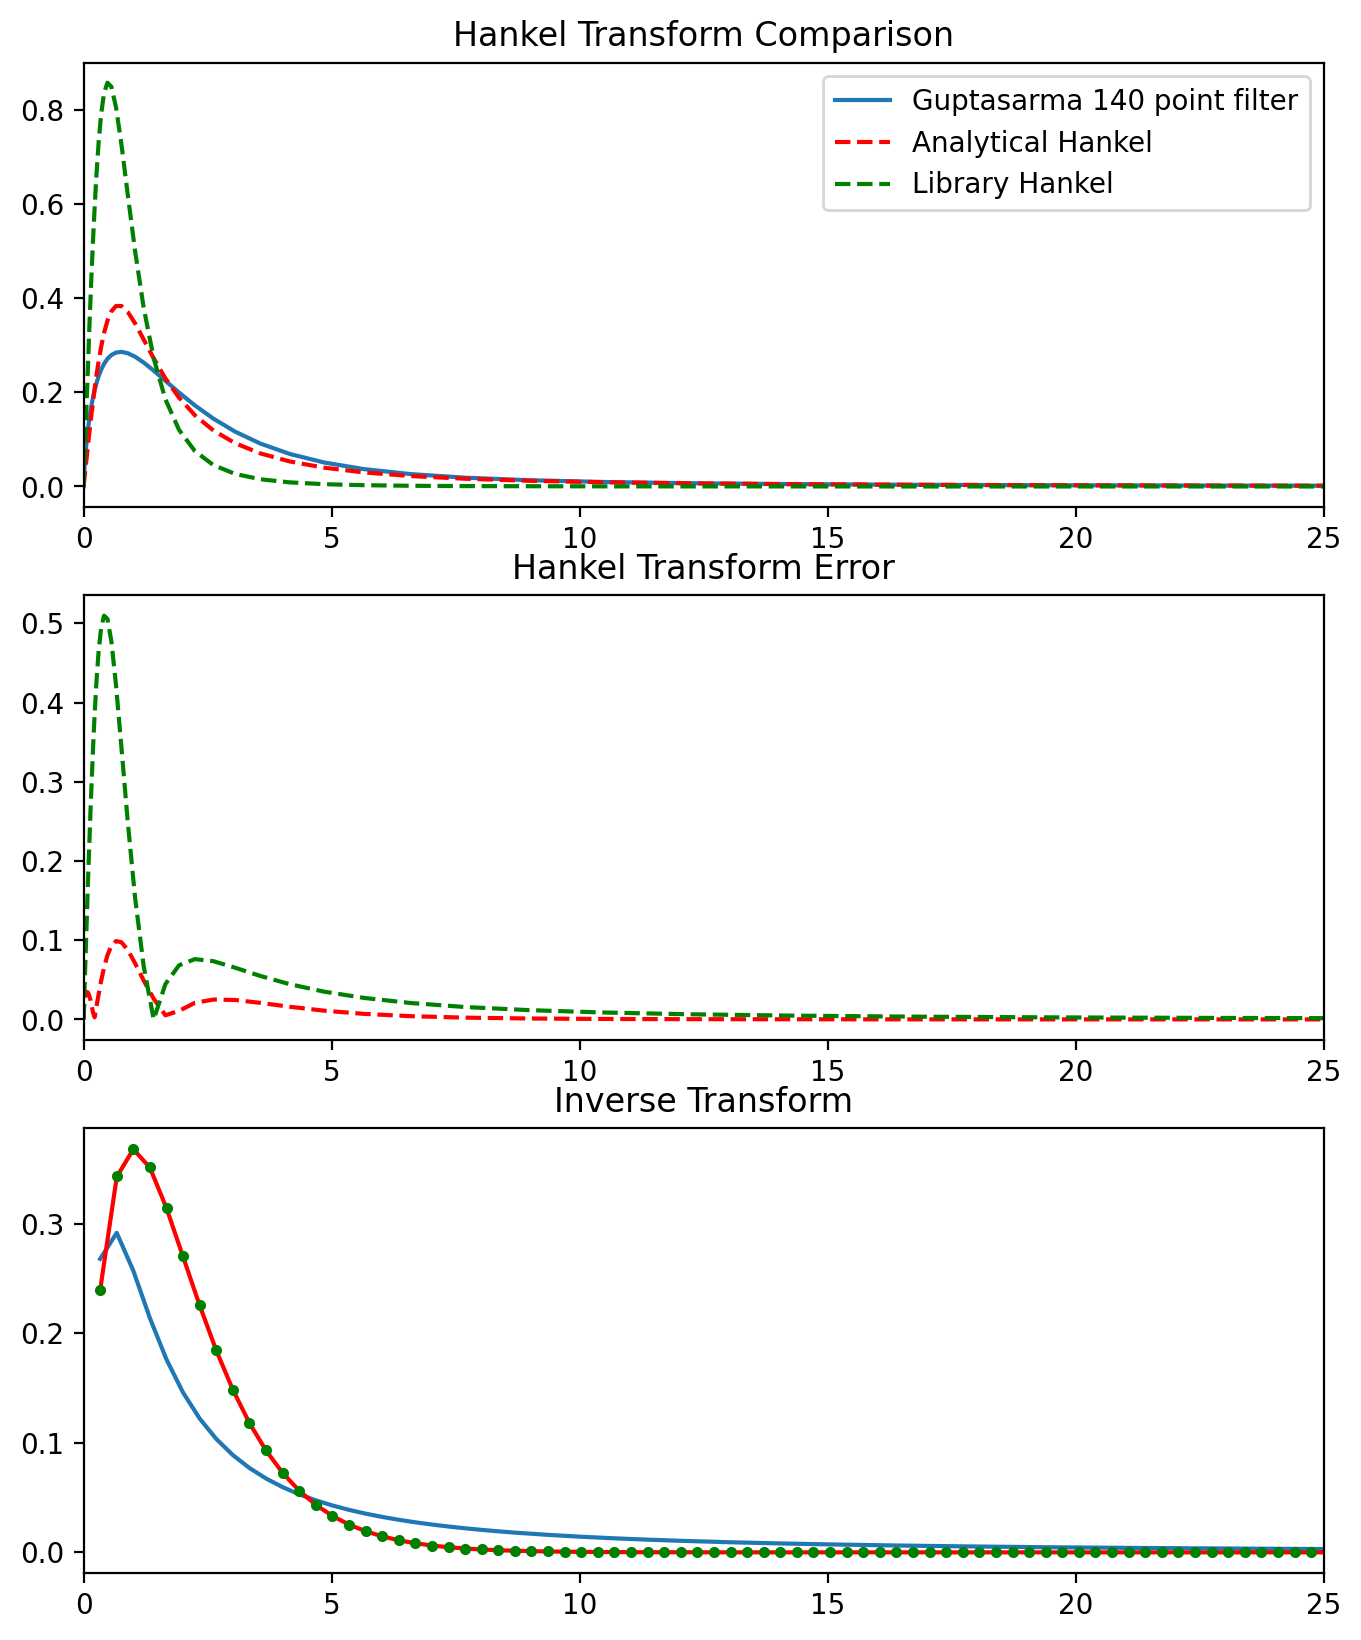

In [15]:
# Input function to test
in_func = tf8
orig_func = f8
# Forward Hankel Testing
filterHankel = filteredHankel(hankelspace, in_func)
analyticalHankel = in_func(hankelspace)
libraryHankel = ht.transform(orig_func, hankelspace, ret_err=False)

# Interpolate spline for to convert points into functions
inversespline_filter = spline(hankelspace, filterHankel)
inversespline_library = spline(hankelspace, libraryHankel)

# Carry out inverse transform
inverse_filter = filteredHankel(realspace, inversespline_filter)
inverse_library = ht.transform(inversespline_library, realspace, inverse=True, ret_err=False)

# Left side is using Guptasarma Filters
plt.figure(figsize=(8,10), dpi=200, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(hankelspace, filterHankel, label='Guptasarma 140 point filter')
plt.plot(hankelspace, analyticalHankel, "r--", label='Analytical Hankel')
plt.plot(hankelspace, libraryHankel, "g--", label='Library Hankel')
plt.xlim([0, 25])
plt.legend()
plt.title('Hankel Transform Comparison')

plt.subplot(312)
plt.title('Hankel Transform Error')
plt.plot(hankelspace, abs(filterHankel-analyticalHankel), "r--")
plt.plot(hankelspace, abs(libraryHankel-analyticalHankel), "g--")
plt.xlim([0, 25])

plt.subplot(313)
plt.title('Inverse Transform')
plt.plot(realspace, inverse_filter)
plt.plot(realspace, orig_func(realspace), 'r')
plt.plot(realspace, inverse_library, 'g.')
plt.xlim([0, 25])
plt.show()


### Messing with pyhank library

In [16]:
from pyhank import HankelTransform as pyhankHT

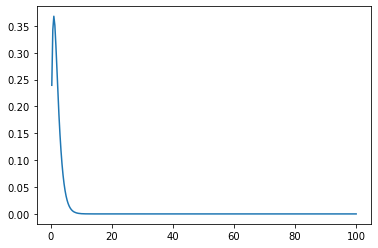

In [22]:
y = f8(realspace)
plt.plot(realspace, y)

array([0.3831706 , 0.70155867, 1.01734681, 1.33236919, 1.64706301,
       1.96158585, 2.27600844, 2.59036721, 2.90468285, 3.21896799])

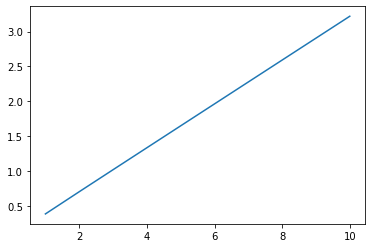

In [44]:
r = np.array([1,2,3,4,5,6,7,8,9,10])
transformer = pyhankHT(order=1, radial_grid=r)
plt.plot(r, transformer.kr)
transformer.kr